In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
from metal.contrib.slicing.synthetics.geometric_synthetics import generate_dataset

In [2]:
from metal.contrib.slicing.online_dp import SliceHatModel, MLPModule
from metal.end_model import EndModel

# NOTE: each model can take a "train_kwargs"

### SHARED PIECES
train_kwargs = {
    "verbose": True,
    "n_epochs": 30,
    "lr": 0.001,
    "l2": 0,
    "disable_prog_bar": True
}
end_model_init_kwargs = {
    "layer_out_dims": [2, 10, 10, 2],
}

### FULL CONFIGS
dp_config = {
    "end_model_init_kwargs": end_model_init_kwargs,
    "train_kwargs": train_kwargs
}

uni_config = {
    "end_model_init_kwargs": end_model_init_kwargs,
    "train_kwargs": train_kwargs
}

up_config = {
    "end_model_init_kwargs": end_model_init_kwargs,
    "upweight_search_space": {"range": [1, 5]},
    "max_search": 5,
    "train_kwargs": train_kwargs
}

moe_config = {
    "end_model_init_kwargs": end_model_init_kwargs,
    "expert_train_kwargs": {"n_epochs": 10, "verbose": False},
    "train_kwargs": {"verbose": False},
    "gating_dim": 5,
    "train_kwargs": train_kwargs
}

print("WARNING: Pay attention to slice weight!")
sm_hat_config = {
    "end_model_init_kwargs": end_model_init_kwargs,
    "slice_kwargs": {
        "slice_weight": 0.1,
        "reweight": True,
    },
    "train_kwargs": train_kwargs
}

sm_on_config = {
    "end_model_init_kwargs": end_model_init_kwargs,
    "slice_kwargs": {
        "L_head_weight": 0.1,
        "Y_head_weight": 0.1 
    },
    "train_kwargs": train_kwargs
}

sm_dp_config = {
    'slice_kwargs': {
        'r': 5,
        'slice_weight': 0.1,
        'reweight': True
    },
    'train_kwargs': train_kwargs,
    'input_module_class': MLPModule,
    'input_module_init_kwargs': {
        'input_dim': 2,
        'output_dim': 5,
        'middle_dims': [5],
        'bias': True
    }
}

In [3]:
%%time
from collections import defaultdict

from metal.label_model import MajorityLabelVoter
from metal.utils import split_data
from metal.contrib.backends.snorkel_gm_wrapper import SnorkelLabelModel
from metal.contrib.slicing.experiment_utils import (
    create_data_loader,
    train_model,
    train_slice_dp,
    search_upweighting_models,
    eval_model
)
from metal.contrib.slicing.utils import get_L_weights_from_targeting_lfs_idx
from metal.contrib.slicing.mixture_of_experts import train_MoE_model


model_configs = {
#     "UNI": uni_config,
#     "UP": up_config,
#     "MoE": moe_config,
    "DP": dp_config,
    'SM_DP': sm_dp_config,
    "SM_HAT": sm_hat_config,
    "SM_ON": sm_on_config,
}

NUM_TRIALS = 5
NUM_SLICES = 4
K = 2
M = 20
N = 10000
unipolar = False
pepper = 0.1
print(f"Pepper: {pepper}")
# A base to add to trial number to set a unique seed for each trial
salt = 15 #np.random.randint(1e6)
print(f"Salt: {salt}")


history = defaultdict(list)
for trial in range(NUM_TRIALS):
    print(f"[Trial {trial}]")

    L_kwargs = {'max_r': 7} if unipolar else {'max_r': 5} 
    Z_kwargs = {'num_slices': NUM_SLICES}
    L, X, Y, Z, targeting_lfs_idx = generate_dataset(K, M, N, 
                                                     L_kwargs=L_kwargs,
                                                     Z_kwargs=Z_kwargs,
                                                     unipolar=unipolar,
                                                     return_targeting_lfs=True,
                                                     seed=(salt + trial),
                                                     plotting=False)

    Ls, Xs, Ys, Zs = split_data(L, X, Y, Z, splits=[0.5, 0.25, 0.25], shuffle=True)
    L_train_raw = Ls[0].copy() # TEMP
    
    for model_name, model_config in model_configs.items():
        print ("-"*10, "Training", model_name, "-"*10)

        Ls[0] = L_train_raw.copy() # TEMP: Reset to unpeppered version
        
        # Generate weak labels:
        if model_name == "UNI":
            Y_train = MajorityLabelVoter().predict_proba(Ls[0])
        else:
            label_model = SnorkelLabelModel()
            label_model.train_model(Ls[0])
            Y_train = label_model.predict_proba(Ls[0])
        Ys[0] = Y_train
        
        from metal.contrib.slicing.utils import add_pepper
        Ls[0] = add_pepper(Ls[0], pepper)        
        
        # Train end model
        if model_name == "UNI":
            model = train_model(model_config, Ls, Xs, Ys, Zs)
        elif model_name == 'UP':
            # generates weighted Y_train and overwrites overwrites Ys[0] internally
            model = search_upweighting_models(model_config, Ls, Xs, Ys, Zs, 
                                              targeting_lfs_idx, verbose=False)
        elif model_name == "MoE":
            model = train_MoE_model(model_config, Ls, Xs, Ys, Zs)
        elif model_name == "DP":
            model = train_model(model_config, Ls, Xs, Ys, Zs)
        elif model_name == "SM_HAT":
            model = train_model(model_config, Ls, Xs, Ys, Zs, model_key="hat")
        elif model_name == "SM_ON":
            model = train_model(model_config, Ls, Xs, Ys, Zs, model_key="online")
        elif model_name == 'SM_DP':
            model = train_slice_dp(model_config, Ls, Xs, Ys, Zs)    
        else:
            raise Exception(f"Unrecognized model_name: {model_name}")
            
        test_loader = create_data_loader(Ls, Xs, Ys, Zs, model_config, 'test')
        results = eval_model(model, test_loader, verbose=False, summary=False)        
        
        # Save results
        history[model_name].append(results)

Pepper: 0.1
Salt: 15
[Trial 0]
---------- Training DP ----------
Added pepper=0.1 random negatives on 0/20 LFs

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): ReLU()
  )
  (3): Linear(in_features=10, out_features=2, bias=True)
)

Saving model at iteration 0 with best score 0.635
[E:0]	Train Loss: 0.699	Dev accuracy: 0.635
Saving model at iteration 1 with best score 0.706
[E:1]	Train Loss: 0.687	Dev accuracy: 0.706
[E:2]	Train Loss: 0.687	Dev accuracy: 0.702
Saving model at iteration 3 with best score 0.721
[E:3]	Train Loss: 0.686	Dev accuracy: 0.721
[E:4]	Train Loss: 0.686	Dev accuracy: 0.696
[E:5]	Train Loss: 0.686	Dev accuracy: 0.717
Saving model at iteration 6 with best score 0.726
[E:6]	Train Loss: 0.686	Dev accuracy: 0.726
[E:7]	Train Loss: 0.686	Dev accuracy: 0.722
Saving model at itera

/Users/vincentchen/miniconda3/envs/slicing/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
/Users/vincentchen/code/metal/metal/contrib/slicing/online_dp.py:159: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  A = F.softmax(self.forward_L(x)).unsqueeze(1)
/Users/vincentchen/code/metal/metal/contrib/slicing/online_dp.py:176: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(self.forward_Y(x)).data.cpu().numpy()


Saving model at iteration 0 with best score 0.641
[E:0]	Train Loss: 17.262	Dev accuracy: 0.641
Saving model at iteration 1 with best score 0.705
[E:1]	Train Loss: 17.194	Dev accuracy: 0.705
Saving model at iteration 2 with best score 0.718
[E:2]	Train Loss: 17.190	Dev accuracy: 0.718
Saving model at iteration 3 with best score 0.738
[E:3]	Train Loss: 17.176	Dev accuracy: 0.738
[E:4]	Train Loss: 17.177	Dev accuracy: 0.720
Saving model at iteration 5 with best score 0.741
[E:5]	Train Loss: 17.171	Dev accuracy: 0.741
Saving model at iteration 6 with best score 0.746
[E:6]	Train Loss: 17.167	Dev accuracy: 0.746
Saving model at iteration 7 with best score 0.749
[E:7]	Train Loss: 17.175	Dev accuracy: 0.749
Saving model at iteration 8 with best score 0.767
[E:8]	Train Loss: 17.166	Dev accuracy: 0.767
[E:9]	Train Loss: 17.164	Dev accuracy: 0.755
Saving model at iteration 10 with best score 0.770
[E:10]	Train Loss: 17.165	Dev accuracy: 0.770
[E:11]	Train Loss: 17.164	Dev accuracy: 0.766
[E:12]	

[E:1]	Train Loss: 0.683	Dev accuracy: 0.654
[E:2]	Train Loss: 0.681	Dev accuracy: 0.654
Saving model at iteration 3 with best score 0.724
[E:3]	Train Loss: 0.680	Dev accuracy: 0.724
[E:4]	Train Loss: 0.680	Dev accuracy: 0.707
Saving model at iteration 5 with best score 0.726
[E:5]	Train Loss: 0.679	Dev accuracy: 0.726
Saving model at iteration 6 with best score 0.760
[E:6]	Train Loss: 0.679	Dev accuracy: 0.760
[E:7]	Train Loss: 0.678	Dev accuracy: 0.737
Saving model at iteration 8 with best score 0.771
[E:8]	Train Loss: 0.678	Dev accuracy: 0.771
[E:9]	Train Loss: 0.678	Dev accuracy: 0.770
Saving model at iteration 10 with best score 0.787
[E:10]	Train Loss: 0.677	Dev accuracy: 0.787
[E:11]	Train Loss: 0.677	Dev accuracy: 0.759
[E:12]	Train Loss: 0.676	Dev accuracy: 0.684
[E:13]	Train Loss: 0.676	Dev accuracy: 0.776
[E:14]	Train Loss: 0.676	Dev accuracy: 0.784
[E:15]	Train Loss: 0.675	Dev accuracy: 0.771
Saving model at iteration 16 with best score 0.802
[E:16]	Train Loss: 0.675	Dev acc

Saving model at iteration 0 with best score 0.712
[E:0]	Train Loss: 19.735	Dev accuracy: 0.712
[E:1]	Train Loss: 19.649	Dev accuracy: 0.699
[E:2]	Train Loss: 19.624	Dev accuracy: 0.652
Saving model at iteration 3 with best score 0.720
[E:3]	Train Loss: 19.610	Dev accuracy: 0.720
[E:4]	Train Loss: 19.600	Dev accuracy: 0.696
[E:5]	Train Loss: 19.594	Dev accuracy: 0.672
[E:6]	Train Loss: 19.592	Dev accuracy: 0.686
[E:7]	Train Loss: 19.586	Dev accuracy: 0.688
[E:8]	Train Loss: 19.581	Dev accuracy: 0.695
Saving model at iteration 9 with best score 0.733
[E:9]	Train Loss: 19.569	Dev accuracy: 0.733
Saving model at iteration 10 with best score 0.738
[E:10]	Train Loss: 19.558	Dev accuracy: 0.738
[E:11]	Train Loss: 19.552	Dev accuracy: 0.728
Saving model at iteration 12 with best score 0.741
[E:12]	Train Loss: 19.535	Dev accuracy: 0.741
[E:13]	Train Loss: 19.528	Dev accuracy: 0.719
Saving model at iteration 14 with best score 0.762
[E:14]	Train Loss: 19.512	Dev accuracy: 0.762
[E:15]	Train Loss

Saving model at iteration 0 with best score 0.582
[E:0]	Train Loss: 0.624	Dev accuracy: 0.582
Saving model at iteration 1 with best score 0.616
[E:1]	Train Loss: 0.622	Dev accuracy: 0.616
[E:2]	Train Loss: 0.622	Dev accuracy: 0.591
Saving model at iteration 3 with best score 0.640
[E:3]	Train Loss: 0.621	Dev accuracy: 0.640
Saving model at iteration 4 with best score 0.644
[E:4]	Train Loss: 0.621	Dev accuracy: 0.644
[E:5]	Train Loss: 0.621	Dev accuracy: 0.614
Saving model at iteration 6 with best score 0.648
[E:6]	Train Loss: 0.621	Dev accuracy: 0.648
[E:7]	Train Loss: 0.621	Dev accuracy: 0.636
[E:8]	Train Loss: 0.620	Dev accuracy: 0.644
[E:9]	Train Loss: 0.620	Dev accuracy: 0.579
Saving model at iteration 10 with best score 0.649
[E:10]	Train Loss: 0.619	Dev accuracy: 0.649
Saving model at iteration 11 with best score 0.683
[E:11]	Train Loss: 0.619	Dev accuracy: 0.683
Saving model at iteration 12 with best score 0.731
[E:12]	Train Loss: 0.618	Dev accuracy: 0.731
Saving model at iterat

Saving model at iteration 0 with best score 0.661
[E:0]	Train Loss: 19.006	Dev accuracy: 0.661
Saving model at iteration 1 with best score 0.695
[E:1]	Train Loss: 18.718	Dev accuracy: 0.695
[E:2]	Train Loss: 18.585	Dev accuracy: 0.683
Saving model at iteration 3 with best score 0.756
[E:3]	Train Loss: 18.473	Dev accuracy: 0.756
Saving model at iteration 4 with best score 0.834
[E:4]	Train Loss: 18.397	Dev accuracy: 0.834
Saving model at iteration 5 with best score 0.850
[E:5]	Train Loss: 18.355	Dev accuracy: 0.850
Saving model at iteration 6 with best score 0.872
[E:6]	Train Loss: 18.347	Dev accuracy: 0.872
[E:7]	Train Loss: 18.337	Dev accuracy: 0.868
Saving model at iteration 8 with best score 0.877
[E:8]	Train Loss: 18.332	Dev accuracy: 0.877
[E:9]	Train Loss: 18.341	Dev accuracy: 0.861
[E:10]	Train Loss: 18.340	Dev accuracy: 0.828
[E:11]	Train Loss: 18.328	Dev accuracy: 0.845
[E:12]	Train Loss: 18.324	Dev accuracy: 0.851
[E:13]	Train Loss: 18.324	Dev accuracy: 0.832
[E:14]	Train Los

Saving model at iteration 2 with best score 0.891
[E:2]	Train Loss: 0.664	Dev accuracy: 0.891
Saving model at iteration 3 with best score 0.892
[E:3]	Train Loss: 0.663	Dev accuracy: 0.892
[E:4]	Train Loss: 0.662	Dev accuracy: 0.891
Saving model at iteration 5 with best score 0.894
[E:5]	Train Loss: 0.661	Dev accuracy: 0.894
[E:6]	Train Loss: 0.660	Dev accuracy: 0.892
[E:7]	Train Loss: 0.660	Dev accuracy: 0.893
[E:8]	Train Loss: 0.660	Dev accuracy: 0.868
Saving model at iteration 9 with best score 0.896
[E:9]	Train Loss: 0.659	Dev accuracy: 0.896
[E:10]	Train Loss: 0.659	Dev accuracy: 0.884
[E:11]	Train Loss: 0.659	Dev accuracy: 0.887
Saving model at iteration 12 with best score 0.899
[E:12]	Train Loss: 0.658	Dev accuracy: 0.899
[E:13]	Train Loss: 0.658	Dev accuracy: 0.890
Saving model at iteration 14 with best score 0.909
[E:14]	Train Loss: 0.658	Dev accuracy: 0.909
[E:15]	Train Loss: 0.658	Dev accuracy: 0.906
[E:16]	Train Loss: 0.658	Dev accuracy: 0.900
Saving model at iteration 17 wi

Saving model at iteration 0 with best score 0.856
[E:0]	Train Loss: 19.680	Dev accuracy: 0.856
Saving model at iteration 1 with best score 0.881
[E:1]	Train Loss: 19.205	Dev accuracy: 0.881
Saving model at iteration 2 with best score 0.898
[E:2]	Train Loss: 19.108	Dev accuracy: 0.898
[E:3]	Train Loss: 19.049	Dev accuracy: 0.895
[E:4]	Train Loss: 19.026	Dev accuracy: 0.894
[E:5]	Train Loss: 19.002	Dev accuracy: 0.898
[E:6]	Train Loss: 18.984	Dev accuracy: 0.897
[E:7]	Train Loss: 18.974	Dev accuracy: 0.895
[E:8]	Train Loss: 18.958	Dev accuracy: 0.892
[E:9]	Train Loss: 18.946	Dev accuracy: 0.896
[E:10]	Train Loss: 18.936	Dev accuracy: 0.892
Saving model at iteration 11 with best score 0.899
[E:11]	Train Loss: 18.931	Dev accuracy: 0.899
[E:12]	Train Loss: 18.923	Dev accuracy: 0.890
[E:13]	Train Loss: 18.916	Dev accuracy: 0.898
[E:14]	Train Loss: 18.915	Dev accuracy: 0.891
[E:15]	Train Loss: 18.911	Dev accuracy: 0.868
Saving model at iteration 16 with best score 0.902
[E:16]	Train Loss: 18.

In [4]:
from metal.contrib.slicing.experiment_utils import parse_history

print(f"Average (n={NUM_TRIALS}):")
df = parse_history(history, NUM_SLICES)
df

Average (n=5):


,DP,SM_DP,SM_HAT,SM_ON
all,0.862480,0.833040,0.877680,0.854800
slice_0,0.858048,0.836740,0.872940,0.854611
slice_1,0.838136,0.845889,0.888890,0.874558
slice_2,0.794664,0.673041,0.857985,0.742260
slice_3,0.831578,0.782013,0.835739,0.852922
slice_avg,0.830606,0.784421,0.863888,0.831088


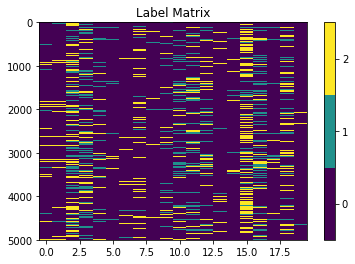

In [5]:
from metal.contrib.visualization.analysis import view_label_matrix
view_label_matrix(Ls[0])